# Utils

Tuto pour démarrer :
https://bhadreshpsavani.medium.com/tutorial-on-sentimental-analysis-using-pytorch-b1431306a2d7

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Paths

In [2]:
root = '/content/drive/MyDrive/Sentiment Analyis'
#root = "/Users/lucienavez/Library/CloudStorage/GoogleDrive-lucienavez@gmail.com/Mon Drive/Sentiment Analyis"

## Imports

In [3]:
# Missing libraries
! pip install bcolz-zipline
! pip install gensim
! pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
! pip install contractions
! pip install bs4

# Basics
import numpy as np
import pandas as pd
import time
import re
import pickle
import bcolz
import matplotlib.pyplot as plt
import contractions
import string
from collections import Counter, OrderedDict
from bs4 import BeautifulSoup

# NLTK
import nltk
nltk.download('wordnet') # for lemmatization
nltk.download('stopwords') # for stopwords
nltk.download('omw-1.4') # Don't know why but code doesn't work (lemmization part)
nltk.download('words')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torchtext.vocab import vocab
from torch.utils.data import TensorDataset, DataLoader
from torchtext.datasets import IMDB


# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Gensim
import gensim
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/nightly/cpu
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 16.5 MB/s 
     |████████████████████████████████| 287 kB 56.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [4]:
# Hardware
if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda


# Parameters

# Dataset
The dataset is downloaded from the following link : 
https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data

This dataset is made of movie review available on amazon

The dataset follows the following format :


2 fields:

- review: text of the review
- sentiment: 2 possible values (positive or negative)

In [ ]:
#Load the data
data_path = root + '/data/IMDB Dataset.csv'

df = pd.read_csv(data_path, encoding='latin-1')
print("Size: ", df.shape)
print(df.head())

FileNotFoundError: ignored

In [ ]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
#Split the data between a training set and a test set
df_train, df_test = train_test_split(df, random_state = 42, shuffle = True, test_size = 0.1)
print(df_train.head())
print(df_test.head())

                                                  review sentiment
40877  I recently started watching this show, and I h...  positive
18057  "Return of the Jedi" is often remembered for w...  positive
19066  I remember I loved this movie when it came out...  negative
20525  I don't know what the last reviewer is talking...  positive
5847   From the very beginning I was so excited to se...  positive
                                                  review sentiment
33553  I really liked this Summerslam due to the look...  positive
9427   Not many television shows appeal to quite as m...  positive
199    The film quickly gets to a major chase scene w...  negative
12447  Jane Austen would definitely approve of this o...  positive
39489  Expectations were somewhat high for me when I ...  negative


In [ ]:
#Create 2 separate csv file in order to load them later
df_train.to_csv(root + '/data/train_imdb.csv', index=True)
df_test.to_csv(root + '/data/test_imdb.csv', index=True)

## Pre-processing

See following links : 
https://medium.com/analytics-vidhya/pre-processing-tweets-for-sentiment-analysis-a74deda9993e
https://towardsdatascience.com/how-to-preprocess-social-media-data-and-text-messages-b011efacf74

Data must be pre-processed in order to be used for training.
For the time being, the only kind of pre-processing that has been applied is removing the emojis.
Howerver, some parts of the tweets may be noisy for the model and would require extra attention : 
- usernames and @ (handles) : @LATimesautos, @kirstiealley, ...
- hashtags : #lebron, #kindle2
- abbreviations : LMAO, pls, DM
- people names + brands : Obama, Kindle, Nike, Susan Boyle
- html characters : &amp, &lt, &gt
- urls and links : http://bit.ly/1e1xQ6, http://t.co/3wEwWZi, http://t.co/3wEwWZi, ...
- weird punctuation : --, -, 
- unexpected lowercases, uppercases
- emojis with punctuation : :), :-), =D
- ...

Analyse data to find out what kind of pre-processing is needed.

1. Put everything to lowercase (in the dataset, it does not seem that lowercase and uppercase play a significant enough role in the sentiment of the tweet)

2. URLs : remove them, they won't be useful for the model
3. HTML characters : remove them, they won't be useful for the model
4. Emojis : I don't know if we should remove them or not, they may be useful for the model because they can be used to express emotions. For instance, we could imagine to replace them by their meaning : :) could be "smile", :D could be "laugh", :/ could be "sad", etc. However, it is not clear that the model will be able to understand the meaning of the emojis. For the time being, I have removed them.
5. Punctuation : remove it, it won't be useful for the model
6. Numbers : remove them, they won't be useful for the model
7. Abbreviations : replace them with their full form, they may be useful for the model. We can maybe use a dictionary to replace them (custom) --> Maybe this is overkill compared to the actual gain of doing that. Or we can use a library like TextBlob to replace them (not custom).
8. Hashtags : remove them, they won't be useful for the model
9. @ : remove them, they won't be useful for the model
10. People names : remove them, they won't be useful for the model
11. Removing stopwords : remove them, they won't be useful for the model

Additionnaly we can use techniques as :
- Lemmatization : converting a word to its base form. For instance : "running" -> "run", "better" -> "good", "am" -> "be", etc.
- Stemming : removing the suffixes of a word. For instance : "running" -> "run", "better" -> "better", "tarts" -> "tart", etc. Only removes suffixes, not prefixes. Stemming is faster than lemmatization but less accurate.

Example where lemmatization and stemming are applied :
- Lemmatization : "Caring" -> "Care"
- Stemming : "Caring" -> "Car"

Obviously, "Care" is not the base form of "Caring" and "Car" is not the base form of "Caring" either.
There are many ways to implement them but the most common one is to use the NLTK package.
https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

## Functions

#### Lemmization, Stemming and Stopwords

In [5]:
def lemmatize(df):
  lemmatizer = WordNetLemmatizer()
  df.text = df.text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

  return df

def stem(df):
  stemmer = nltk.stem.PorterStemmer()
  df.text = df.text.apply(lambda x: [stemmer.stem(word) for word in x])

  return df

def removeStopwords(df):
  english_stopwords = stopwords.words('english')
  df.text = df.text.apply(lambda x: [item for item in x if item not in english_stopwords])

  return df

def expandContractions(df):
  df.text = df.text.apply(lambda x: [contractions.fix(word) for word in x])

  return df

In [6]:
def preProcess(df, lemmatization = True, stemming = False, remove_stopwords = True):
  
  # Lowercase the text
  df.text = df.text.str.lower()
  # Remove urls 
  df.text = df.text.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
  df.text = df.text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
  # Remove html reference characters
  df.text = df.text.apply(lambda x: re.sub(r'&[a-z]+;', '', x))
  # Remove hashtags (must be done before removing punctuation)
  df.text = df.text.apply(lambda x: re.sub(r'#', '', x))
  # Remove mentions (must be done before removing punctuation)
  df.text = df.text.apply(lambda x: re.sub(r'@\w+', '', x))
  # Remove numbers
  df.text = df.text.apply(lambda x: re.sub(r'\d+', '', x))

  # Remove special characters
  df.text = df.text.apply(lambda x: re.sub(r'\[[^]]*\]', '', x))
  df.text = df.text.apply(lambda x: re.sub(r'[^a-zA-z0-9\s]', '', x))

  print("Special characters removed")

  # Tokenize
  tokenizer = torchtext.data.utils.get_tokenizer("basic_english")
  df['text'] = df.apply(lambda row: tokenizer(row['text']), axis=1)

  print("Text tokenized")

  # Expand contractions
  df = expandContractions(df)

  if remove_stopwords:
    # Remove stopwords
    df = removeStopwords(df)

  print("Stop words removed")
    
  if lemmatization:
    # Lemmatization
    df = lemmatize(df)

  if stemming:
    # Stemming
    df = stem(df)

  print("Lemmatized and stemmatized")

    
  # Remove punctuation tokens in each row of the text column
  df.text = df.text.apply(lambda x: [item for item in x if item not in string.punctuation])
  # Remove any weird characters tokens
  df.text = df.text.apply(lambda x: [item for item in x if item.isalpha()])
  # Remove any tokens with length less than 2
  df.text = df.text.apply(lambda x: [item for item in x if len(item) > 2])
  # Remove any repeated tokens
  df.text = df.text.apply(lambda x: list(OrderedDict.fromkeys(x)))

  print("Punctuation removed")

  # Remove any non-english words
  english_words = set(nltk.corpus.words.words())
  df.text = df.text.apply(lambda x: [item for item in x if item in english_words])

  print("Non-english words removed")

  return df

In [7]:
def loadData(data_path):
  # Load CSV file
  df = pd.read_csv(data_path, encoding='latin-1')

  # Add sentiment and text column header
  column_names = ['text', 'sentiment']
  df = pd.DataFrame(zip(df.iloc[:, 1], df.iloc[:, 2]), columns=column_names)

  # Pre-process
  df = preProcess(df)

  # Vocabulary size 
  # Build the vocabulary
  voc = set()
  for text in df.text:
    for word in text:
      voc.add(word)

  return df, len(voc), voc

In [8]:
# Read the data at the path
data_path = root + '/data/'
print("Loading train data...")
df_train, vocab_size_train, voc_train = loadData(data_path + 'train_imdb.csv')
print("\nLoading test data...")
df_test, vocab_size_test, voc_test = loadData(data_path + 'test_imdb.csv')

Loading train data...
Special characters removed
Text tokenized
Stop words removed
Lemmatized and stemmatized
Punctuation removed
Non-english words removed

Loading test data...
Special characters removed
Text tokenized
Stop words removed
Lemmatized and stemmatized
Punctuation removed
Non-english words removed


In [9]:
print("Train size: ", df_train.text.size)
print(df_train.sentiment.value_counts())
print(df_train.head())

Train size:  45000
negative    22519
positive    22481
Name: sentiment, dtype: int64
                                                text sentiment
0  [recently, watching, show, say, really, made, ...  positive
1  [return, often, wrong, rather, right, shame, l...  positive
2  [remember, movie, came, year, old, commodore, ...  negative
3  [know, last, reviewer, talking, show, pure, en...  positive
4  [beginning, excited, see, movie, poster, possi...  positive


In [10]:
print("Test size: ", df_test.text.size)
print(df_test.sentiment.value_counts())
print(df_test.head())

Test size:  5000
positive    2519
negative    2481
Name: sentiment, dtype: int64
                                                text sentiment
0  [really, due, look, arena, curtain, overall, i...  positive
1  [many, television, show, appeal, quite, differ...  positive
2  [film, quickly, get, major, chase, scene, ever...  negative
3  [jane, would, definitely, approve, awesome, jo...  positive
4  [expectation, somewhat, high, went, see, movie...  negative


In [ ]:
print('Train data shape: ', df_train.shape)
print('Test data shape: ', df_test.shape)
print('Vocabulary size: ', vocab_size_train)
print('Vocabulary size: ', vocab_size_test)
print('Vocabulary train: ', list(voc_train)[:10])
print('Vocabulary test: ', list(voc_test)[:10])
print('Train data sample: \n', df_train.head())
print('Test data sample: \n', df_test.head())

Train data shape:  (45000, 2)
Test data shape:  (5000, 2)
Vocabulary size:  30615
Vocabulary size:  17650
Vocabulary train:  ['sickeningly', 'wary', 'sagittarius', 'outwit', 'progovernment', 'indignation', 'employed', 'unyieldingly', 'insufficiency', 'asbestos']
Vocabulary test:  ['restrictive', 'sickeningly', 'variously', 'wary', 'veer', 'snuggle', 'diversity', 'nodule', 'escapist', 'outwit']
Train data sample: 
                                                 text sentiment
0  [recently, watching, show, say, really, made, ...  positive
1  [return, often, wrong, rather, right, shame, l...  positive
2  [remember, movie, came, year, old, commodore, ...  negative
3  [know, last, reviewer, talking, show, pure, en...  positive
4  [beginning, excited, see, movie, poster, possi...  positive
Test data sample: 
                                                 text sentiment
0  [really, due, look, arena, curtain, overall, i...  positive
1  [many, television, show, appeal, quite, differ...  posi

## Build vocabulary

In [ ]:
# Build the vocabulary for the training data
vocabulary = set()

# Add special tokens to the vocabulary
pad = "<PAD>" # Used to pad short sentences to the MAX_TOKENS length
sos = "<SOS>" # Start-of-sentence
eos = "<EOS>" # End-of-sentence
ukn = "<UKN>" # Unknown word

vocabulary.add(pad)
vocabulary.add(sos)
vocabulary.add(eos)
vocabulary.add(ukn)


MAX_TOKENS = 0 # Maximum number of tokens in a sentence

# Iterate over the training data
for row in range(len(df_train)):
      # Each row["text"] is a list of tokens
      # Each token is a word that has to be added to the vocabulary
      MAX_TOKENS = max(MAX_TOKENS, len(df_train.loc[row, "text"]))
      # Save the row that has the maximum number of tokens
      if MAX_TOKENS == len(df_train.loc[row, "text"]):
        max_row = df_train.loc[row, "text"]
        row_index = row
      tokens = df_train.loc[row, "text"]
      for word in tokens:
        vocabulary.add(word)
            
vocab_size = len(vocabulary)

In [ ]:
print(MAX_TOKENS)
print(vocab_size)
print(max_row)

692
30619
['spoiler', 'although', 'many', 'commentator', 'film', 'term', 'fit', 'poorly', 'quote', 'encyclopedia', 'fantastic', 'incongruous', 'imagery', 'one', 'explain', 'unimaginative', 'way', 'plucky', 'boy', 'large', 'seeking', 'fortune', 'driver', 'seat', 'red', 'mustang', 'could', 'curious', 'might', 'read', 'said', 'lad', 'behind', 'wheel', 'sport', 'car', 'surely', 'protest', 'fantasy', 'incongruity', 'offer', 'mostly', 'appear', 'within', 'first', 'fifteen', 'minute', 'thereafter', 'get', 'iteration', 'squalid', 'progression', 'far', 'soon', 'prof', 'predictable', 'hand', 'literally', 'believable', 'unfair', 'tax', 'particular', 'flaw', 'plausible', 'suspension', 'disbelief', 'fallen', 'precipitously', 'typical', 'viewer', 'scale', 'value', 'ever', 'since', 'raider', 'lost', 'ark', 'hallucinatory', 'know', 'hallucination', 'part', 'knowing', 'rate', 'people', 'enjoy', 'drug', 'result', 'loss', 'anyone', 'would', 'take', 'course', 'occasional', 'bad', 'trip', 'movie', 'must', 

In [ ]:
# For each word in the vocabulary, assign a word id
word2index = {}
for index, word in enumerate(vocabulary):
    word2index[word] = index

In [ ]:
# For each word id, assign a word
index2word = {id: token for token, id in enumerate(word2index)}

In [ ]:
print(word2index["<SOS>"])

25277


In [ ]:
# To have an idea, compute statistics on the number of tokens in each sentence
mean = 0
for row in range(len(df_train)):
    mean += len(df_train.loc[row, "text"])
mean = mean / len(df_train)
print("Mean length of sentences : ", mean)

Mean length of sentences :  77.49162222222222


## Build Embedding
https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
Embedding converts words to integers, and there is a vector corresponding to eachinteger.
If there x words in a dictionary, each word will be assigned a value between 1 and x.

Embedding types : 
- GloVe : Global Vectors for Word Representation (pre-trained)
- Word2Vec : 
    - Pre-trained : https://github.com/AI-Trends/NLP-Tutorial/blob/master/Word2vec_pretrained_embeddings.ipynb
This first version of word2vec embedding will load the vectors of an already trained model.
    - Trained on the fly : https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis
Unlike the previous version, we will build a vocabulary and train it with the train dataset from our data.
- FastText : Facebook AI Research


### Embedding matrix
When we will have a dataset, its vocabulary, and a dictionary of embedder words and their corresponding vectors.
There will still be no correlation between our vocabulary, and the embedder vocabulary.
To connect them, we need to create an embedding matrix.

In [ ]:
def build_embedding_matrix(vocab_size, embedding_dim, vocabulary, embedding, glove, model):
    print("Building embedding matrix...")

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    # This matrix needs to be populated : 
    #   For each word in the training vocabulary, the corresponding vector is 
    #   retrieved from the GloVe dictionary

    ukn_cnt = 0     # unknown words counter
    ukn_set = set() # set of unknown words
    for index, word in enumerate(vocabulary):
        if word in embedding:
          if glove:
            embedding_matrix[index] = embedding[word]
          else:
            embedding_vector = model[word]
            embedding_vector = np.array(embedding_vector)
            if embedding_vector is not None:
              embedding_matrix[index] = embedding_vector
        else:
            ukn_cnt += 1
            ukn_set.add(word)
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(embedding_dim, ))
    
    print("Unknown words: ", ukn_cnt)
    print("Percentage of unknown words: ", ukn_cnt / vocab_size)
    
    return embedding_matrix

In [ ]:
# Choose the embedding parameters
EMBEDDING_TYPE = "glove" # "glove" (pre-trained), "word2vec" or "fasttext"
PRE_TRAINED = True # True if using pre-trained embeddings, False otherwise
RETRAIN_EMBEDDINGS = False # True if training the embeddings, False otherwise

#-----------------------------------------
#                  GloVe 
#-----------------------------------------
if EMBEDDING_TYPE == "glove":
    if PRE_TRAINED:
        print("Loading pre-trained GloVe embeddings...")
        embedding_path = root + '/Glove/glove.42B.300d.txt'
        embedding_dim = 300 # The dimension of the embedding
        
        embedding_dict = {}
        with open(embedding_path, 'r') as f:
            for line in f:
                tokens = line.split()
                word = tokens[0]
                vector = np.array(tokens[1:], dtype=np.float32)
                if vector.shape[0] == embedding_dim:
                    embedding_dict[word] = vector
                else:
                    print("Error: embedding dimension is not ", embedding_dim)
        
        # Create the embedding matrix   
        embedding = build_embedding_matrix(vocab_size, embedding_dim, vocabulary, embedding_dict, True, embedding_dict)
                
#-----------------------------------------
#                  Word2Vec 
#-----------------------------------------             
elif EMBEDDING_TYPE == "word2vec":
    if PRE_TRAINED:
        print("Loading pre-trained Word2Vec embeddings...")
        
        embedding_path = root + '/Word2Vec/GoogleNews-vectors-negative300.bin'
        embedding_dim = 300 # The dimension of the embedding
        
        # Load the vocabulary and the corresponding vectors
        model_w2v = KeyedVectors.load_word2vec_format(root + '/Word2Vec/GoogleNews-vectors-negative300.bin', binary=True)
        embedding_dict = model_w2v.vocab
        
        # Create the embedding matrix
        embedding = build_embedding_matrix(vocab_size, embedding_dim, vocabulary, embedding_dict, False, model_w2v)
    
    else:
        if RETRAIN_EMBEDDINGS:
            print("Training Word2Vec embeddings...")
            #-----------------------------------------
            #                 Parameters
            #-----------------------------------------
            
            embedding_dim = 300
            w2v_window = 5
            w2v_min_count = 10
            w2v_workers = 8
            train_embeddings_epochs = 30
            
            # Train the word2vec model
            model_w2v = gensim.models.word2vec.Word2Vec(size=embedding_dim, window=w2v_window, min_count=w2v_min_count, workers=w2v_workers)
            model_w2v.build_vocab(df_train.text)
            words = model_w2v.wv.vocab.keys()
            model_w2v.train(df_train.text, total_examples=len(df_train), epochs=train_embeddings_epochs)
            model_w2v.save(root + "/Word2Vec/w2v.model")
            embedding_dict = model_w2v.wv
            
            # Create the embedding matrix
            embedding = build_embedding_matrix(vocab_size, embedding_dim, vocabulary, embedding_dict, False, model_w2v)
            
        else:
            print("Loading Word2Vec embeddings...")
            # Can avoid the training by loading the saved model
            model_w2v = gensim.models.word2vec.Word2Vec.load(root + '/Word2Vec/w2v.model')
            embedding_dim = 300
            embedding_dict = model_w2v.wv
        
            # Create the embedding matrix
            embedding = build_embedding_matrix(vocab_size, embedding_dim, vocabulary, embedding_dict, False, model_w2v)
            
elif EMBEDDING_TYPE == "fasttext":
    if PRE_TRAINED:
        print("Loading pre-trained FastText embeddings...")
        
        embedding_path = root + '/FastText/wiki-news-300d-1M.vec'
        embedding_dim = 300
        
        # Load the vocabulary and the corresponding vectors
        embedding_dict = {}
        with open(embedding_path, 'r') as f:
            for line in f:
                tokens = line.split()
                word = tokens[0]
                vector = np.array(tokens[1:], dtype=np.float32)
                if vector.shape[0] == embedding_dim:
                    embedding_dict[word] = vector
                else:
                    print("Error: embedding dimension is not ", embedding_dim)
                    
        # Create the embedding matrix
        embedding = build_embedding_matrix(vocab_size, embedding_dim, vocabulary, embedding_dict)

Loading pre-trained GloVe embeddings...
Building embedding matrix...
Unknown words:  601
Percentage of unknown words:  0.019628335347333357


In [ ]:
# Check dictionary size : 
print("Dictionary Size : ", len(embedding_dict))

Dictionary Size :  1917494


## Padding sequences
Some of the tweets are longer than others. 
In order to train the model on a fixed-length input, we must define an input length that will be the same for all tokens (MAX_TOKENS), and pad all tweets that are smaller than MAX_TOKENS with \<PAD\> tokens

In [ ]:
# Decide on the maximum length of the sequences (based on the mean computed earlier)
seq_length = 100 # mean was around 77

In [ ]:
#Returns the index if the word is in the vocabulary, otherwise, it returns the index of unkwon words
def get_word(w):
  if w in word2index:
    return word2index[w]
  else:
    return word2index["<UKN>"]

In [ ]:
def padding_and_encode(tweet, max_length):
  sos_id = [word2index["<SOS>"]]
  eos_id = [word2index["<EOS>"]]
  pad_id = [word2index["<PAD>"]]
  
  # Truncate the tweet if it is too long (more than seq_length)
  if len(tweet) > max_length:
    tweet = tweet[:max_length]
    n_pads = 0
  else:
    n_pads = max_length - len(tweet)
    
  encoded = [get_word(w) for w in tweet] # encode without embedding here!!!
  return sos_id + encoded + eos_id + pad_id*n_pads

In [ ]:
# Transfrom dataframes into lists
X_train = df_train["text"].tolist()
X_test = df_test["text"].tolist()
y_train = df_train["sentiment"].tolist()
y_test = df_test["sentiment"].tolist()

In [ ]:
# Print the 10 first elements of the training set
for i in range(10):
  print(X_train[i], y_train[i])

['recently', 'watching', 'show', 'say', 'really', 'made', 'laugh', 'appreciate', 'unrealistic', 'aspect', 'along', 'everything', 'else', 'people', 'said', 'realistic', 'reaction', 'dead', 'among', 'thing', 'going', 'accept', 'bring', 'back', 'life', 'completely', 'crazy', 'bit', 'help', 'smiling', 'every', 'episode', 'watched', 'think', 'great', 'take', 'strange', 'subject', 'make', 'watch', 'absolutely', 'love', 'narration', 'add', 'extra', 'wonder', 'whole', 'cannot', 'always', 'compare', 'old', 'writer', 'new', 'one', 'entity', 'definitely', 'give', 'chance', 'enjoy', 'ridiculous', 'part'] positive
['return', 'often', 'wrong', 'rather', 'right', 'shame', 'last', 'chronological', 'installment', 'star', 'war', 'saga', 'shining', 'example', 'epic', 'storytelling', 'wrap', 'story', 'line', 'previous', 'movie', 'one', 'grand', 'finale', 'yes', 'cute', 'cuddly', 'bear', 'broaden', 'demographic', 'middle', 'slow', 'bit', 'final', 'hour', 'best', 'piece', 'entire', 'luke', 'finally', 'come'

In [ ]:
# Encode 
X_train = [padding_and_encode(tweet, seq_length-2) for tweet in X_train] # -2 because of SOS and EOS
X_test = [padding_and_encode(tweet, seq_length-2) for tweet in X_test] # -2 because of SOS and EOS
# Make sure that the values in y_train are either 0 (0) or 1 (instead of 4)
y_train = [0 if y == 'negative' else 1 for y in y_train]
y_test = [0 if y == 'negative' else 1 for y in y_test]

In [ ]:
for i, j in zip(X_train[:3], y_train[:3]):
  print(i, j)

[25277, 11315, 25488, 4949, 9405, 25857, 23652, 24963, 22946, 16510, 21349, 16584, 3592, 18938, 22924, 24544, 28420, 10945, 18319, 16541, 25888, 8099, 20347, 17490, 15425, 23192, 24353, 25047, 26735, 1119, 11480, 2882, 13366, 15397, 24062, 16142, 7587, 1124, 15857, 18189, 3865, 17271, 6827, 6105, 2207, 580, 15105, 20325, 1435, 14988, 3242, 16144, 17508, 12839, 6466, 20883, 30230, 9523, 5686, 7636, 21688, 5990, 4656, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012, 13012] 1
[25277, 1154, 18748, 24844, 12269, 28771, 6024, 30292, 5416, 24143, 17534, 8041, 12417, 8825, 8155, 24126, 25403, 25556, 10908, 23111, 22173, 29443, 6466, 4105, 25401, 24460, 14132, 14861, 27941, 30336, 2155, 19289, 23573, 26735, 341, 3489, 28716, 21628, 14190, 29978, 5813, 2058, 29125, 12635, 11912, 6503, 25888, 2292

Since we only have a training set and test set, we split the training set into training and validation set.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  random_state = 42, 
                                                  shuffle = True, 
                                                  test_size = 0.2)

# Now truncate the dataset because there is too much data
keep_ratio = 1
X_train, y_train = X_train[:int(len(X_train)*keep_ratio)], y_train[:int(len(y_train)*keep_ratio)]
X_val, y_val = X_val[:int(len(X_val)*keep_ratio)], y_val[:int(len(y_val)*keep_ratio)]

print("Number of training examples : ", len(X_train))
print("Number of validation examples : ", len(X_val))


Number of training examples :  36000
Number of validation examples :  9000


In [ ]:
for i, j in zip(X_train[:3], y_train[:3]):
  print(i, j)

[25277, 29182, 15915, 1089, 19633, 5639, 1831, 24779, 2882, 14502, 15278, 436, 25103, 6812, 28475, 13378, 8358, 4748, 20185, 24284, 13957, 6150, 29443, 24601, 22639, 29271, 10419, 21055, 10940, 9466, 30310, 23072, 14434, 14915, 22025, 7852, 20568, 13693, 30438, 1079, 383, 3290, 16620, 9006, 9467, 9434, 18966, 8844, 7085, 20533, 12839, 29866, 11031, 8443, 14586, 7228, 27104, 10908, 3396, 14652, 11098, 15243, 14988, 5028, 12873, 9510, 21396, 28716, 23111, 11566, 27940, 4588, 3545, 20325, 22887, 11074, 10694, 1435, 16858, 7752, 678, 22438, 7253, 12824, 7570, 29423, 7444, 4613, 18592, 21760, 9523, 12539, 15028, 14838, 20588, 20646, 13292, 30041, 1034, 4656] 1
[25277, 6503, 19551, 321, 25837, 23225, 24796, 4949, 6466, 28716, 22, 25857, 22946, 546, 9414, 25941, 23503, 14989, 21935, 7492, 27590, 8525, 21, 5437, 17155, 16144, 11773, 7236, 9531, 8099, 2174, 22670, 3326, 29336, 16182, 20381, 28833, 23334, 127, 3405, 5250, 29125, 24040, 11254, 610, 12097, 23084, 10874, 29388, 18033, 16962, 23192,

# DataLoaders

In [ ]:
batch_size = 10

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))


# DataLoaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size = batch_size, drop_last=True)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size = batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=len(X_test), drop_last=True)

# Document embedding
The document embedding will work in a different way from the word embedding. Instead of uwing an embedding layer into our RNN, we will directly transform the document into its embedded vector and provide that vector as an input to the RNN. This will thus require to use a RNN a bit modified from the previous one.

In [46]:
document_model = "doc2vec"
#document_model = "word2vec-tfidf"

embedding_dim = 300

new_df_train = np.zeros((len(df_train), embedding_dim))
new_df_test = np.zeros((len(df_test), embedding_dim))
i = 0

if document_model == "doc2vec":

  print("Loading doc2vec...")

  d2v_model = Doc2Vec(vector_size=embedding_dim, min_count=2, epochs=30)

  sentences = [TaggedDocument(sentence, [i]) for i,sentence in enumerate(df_train.text)]

  d2v_model.build_vocab(sentences)
  d2v_model.wv.vocab
  d2v_model.train(sentences, total_examples=len(sentences), epochs=30)

  for sentence in df_train.text:
    new_df_train[i] = d2v_model.infer_vector(sentence)
    i += 1

  i = 0
  for sentence in df_test.text:
    new_df_test[i] = d2v_model.infer_vector(sentence)
    i += 1

elif document_model == "word2vec-tfidf":

  print("Loading word2vec averaged with tf-idf...")

  # Loading word2vec
  embedding_path = root + '/Word2Vec/GoogleNews-vectors-negative300.bin'
        
  # Load the vocabulary and the corresponding vectors
  model_w2v = KeyedVectors.load_word2vec_format(root + '/Word2Vec/GoogleNews-vectors-negative300.bin', binary=True)

  dictionary = Dictionary()
  bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in df_train.text]

  tfidf = TfidfModel(bow_corpus, smartirs='ntc')

  unknown = 0
  num_words = 0
  #i = 0

  for doc in tfidf[bow_corpus]:
    if i % 5000 == 0:
      print(i, "/", len(df_train))

    total_freq = 0 #used to normalize the weigths

    for id, freq in doc:
      total_freq += freq

    #Bulding the vector for each document
    for id, freq in doc: 
      num_words += 1
      word = dictionary[id]
      #print(word)
      if word in model_w2v.vocab:
        embedding_vector = model_w2v[word]
        embedding_vector = np.array(embedding_vector)
        new_df_train[i] += (freq/total_freq)*embedding_vector
      else:
        unknown += 1

    i += 1

  print(unknown/num_words)

  # Now we do the same but for df_test
  unknown = 0
  num_words = 0
  i = 0
  dictionary = Dictionary()
  bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in df_test.text]

  tfidf = TfidfModel(bow_corpus, smartirs='ntc')

  for doc in tfidf[bow_corpus]:
    if i % 500 == 0:
      print(i, "/", len(df_test))

    total_freq = 0 #used to normalize the weigths

    for id, freq in doc:
      total_freq += freq

    #Bulding the vector for each document
    for id, freq in doc: 
      num_words += 1
      word = dictionary[id]
      #print(word)
      if word in model_w2v.vocab:
        embedding_vector = model_w2v[word]
        embedding_vector = np.array(embedding_vector)
        new_df_test[i] += (freq/total_freq)*embedding_vector
      else:
        unknown += 1

    i += 1
  print(unknown/num_words)

  

Loading doc2vec...


In [47]:
print(new_df_test.shape)
print(new_df_train.shape)

(5000, 300)
(45000, 300)


In [48]:
y_train = df_train["sentiment"].tolist()
y_test = df_test["sentiment"].tolist()
y_train = [0 if y == 'negative' else 1 for y in y_train]
y_test = [0 if y == 'negative' else 1 for y in y_test]

In [49]:
X_train, X_val, y_train, y_val = train_test_split(new_df_train, y_train, 
                                                  random_state = 42, 
                                                  shuffle = True, 
                                                  test_size = 0.2)

In [50]:
print(X_train[0].shape)

(300,)


In [51]:
batch_size = 10

X_train = [[doc] for doc in X_train]
X_train = np.array(X_train)
print(X_train.shape)
X_test = [[doc] for doc in new_df_test]
X_test = np.array(X_test)
X_val = [[doc] for doc in X_val]
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size = batch_size, drop_last=True)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size = batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, drop_last=True)

(36000, 1, 300)


# Model architecture
To train the model, we will use the following architectures :
- RNN : 
  - Embedding layer (pre-trained GloVe, Word2Vec, FastText)
    https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
    The weights of the embedding_matrix will be loaded into that layer.
  - LSTM layer or GRU layer
  - Linear layer

Or we can use the following architecture :
- Transformer architecture (self attention)

Or the following architecture : 
- RNN + Attention
  - Embedding layer (pre-trained GloVe, Word2Vec, FastText)
  - LSTM layer or GRU layer
  - Attention layer
  - Linear layer

In [ ]:
def CreateEmbeddingLayer(embedding_matrix, padding_id, non_trainable=False):
  # Retrieve dimensions of embedding
  num_embeddings, embedding_dim = embedding_matrix.shape

  # Initialize nn.Embedding with the pre-trained weights
  embedding_layer = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_id)
  embedding_layer.load_state_dict({'weight': torch.from_numpy(embedding_matrix)})

  if non_trainable:
    embedding_layer.weight.requires_grad = False

  return embedding_layer, num_embeddings, embedding_dim

In [ ]:
def positional_encoding(seq_length, embedding_dim):
  pos_enc = np.array([
      [pos / np.power(10000, 2 * (j // 2) / embedding_dim) for j in range(embedding_dim)]
      if pos != 0 else np.zeros(embedding_dim) for pos in range(seq_length)
  ])
  pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
  pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
  
  return torch.from_numpy(pos_enc).type(torch.FloatTensor).to(device)

## RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, dropout, bidirectional, padding_id, num_layers, type):
      super().__init__()

      # Embedding layer
      self.embedding, num_embeddings, embedding_dim = CreateEmbeddingLayer(embedding_matrix, padding_id, True)

      # LSTM or GRU
      if type=="LSTM":
        self.model = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            batch_first = True, 
                            dropout = dropout,
                            bidirectional = bidirectional)
      elif type=="GRU":
        self.model = nn.GRU(embedding_dim,
                            hidden_dim,
                            num_layers = num_layers,
                            dropout = dropout,
                            bidirectional = bidirectional)

      # Fully-connected layer
      self.fc = nn.Linear(hidden_dim * 2, 2)
      # The output of the fully connected layer is a vector of size 2 containing
      # the probability of the tweet to belong to either positive or negative
      # class (--> 2 classes)

      # Dropout
      self.dropout = nn.Dropout(dropout)

    def forward(self, input):

      # Embed the input
      embs = self.dropout(self.embedding(input))

      # pack sequence
      # lengths need to be on CPU!
      # This will cause the RNN to only process non-padded elements
      #packed_embedded = nn.utils.rnn.pack_padded_sequence(embs, input_length.to('cpu'))

      # Feed embeddings to LSTM
      packed_output, (hidden, cell) = self.model(embs)

      # Apply droupout
      # Dropout is applied to the concatenation of the final forward and backward hidden layers
      # (Because of bidirectionality)
      out = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

      # Through fully connected layer
      out = self.fc(out)

      return out
    
    def init_hidden(self):
      """At the beginning of the sequence, there are no hidden state.
          Thus, we need to initialise the hidden state vector."""

      return (torch.zeros(2, batch_size, 32), torch.zeros(2, batch_size, 32))


## Transformer

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embedding_dim):
    super(SelfAttention, self).__init__()
    self.embedding_dim = embedding_dim
    self.query = nn.Linear(embedding_dim, embedding_dim)
    self.key = nn.Linear(embedding_dim, embedding_dim)
    self.value = nn.Linear(embedding_dim, embedding_dim)
    self.scale = torch.sqrt(torch.FloatTensor([embedding_dim])).to(device)
    self.softmax = nn.Softmax(dim=-1)
    self.dropout = nn.Dropout(0.1)
    self.out = nn.Linear(embedding_dim, embedding_dim)
  
  def forward(self, x):
    batch_size = x.shape[0]
    # x = [batch size, seq len, embedding dim]
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)
    # Q, K, V = [batch size, seq len, embedding dim]
    energy = torch.matmul(Q, K.permute(0, 2, 1)) / self.scale
    # energy = [batch size, seq len, seq len]
    attention = self.softmax(energy)
    # attention = [batch size, seq len, seq len]
    x = torch.matmul(self.dropout(attention), V)
    # x = [batch size, seq len, embedding dim]
    x = self.out(x)
    # x = [batch size, seq len, embedding dim]
    return x, attention

In [ ]:
# Attention layer
class TransformerAttention(nn.Module):
  def __init__(self, embedding_matrix, heads, padding_id, max_sequence_length, dropout=0.1):
    super(TransformerAttention, self).__init__()
    
    # Embedding layer
    self.embedding, num_embeddings, embedding_dim = CreateEmbeddingLayer(embedding_matrix, padding_id, True)
    self.embedding_dim = embedding_dim
    self.heads = heads
    self.head_dim = embedding_dim // heads
    self.max_sequence_length = max_sequence_length
    
    assert (self.head_dim * heads == embedding_dim), "Embedding dimension should be divisible by heads"

    self.attention = SelfAttention(self.embedding_dim)
    self.dropout = nn.Dropout(dropout)
    # Linear layer of size d_model * d_model
    self.fc = nn.Linear(self.embedding_dim, self.embedding_dim)
    # Linear project layer of size d_model * d_classes
    self.fc_out = nn.Linear(embedding_dim, 2)

  def forward(self, inputs):
    # Fetch embedding from input
    embs = self.embedding(inputs)
    
    # Embeddings are fed in as (batch_size, seq_length, embedding_dim)
    # Add position encoding to the embeddings
    embs = embs + positional_encoding(self.max_sequence_length, self.embedding_dim)
    
    # Apply dropout
    embs = self.dropout(embs) # (batch_size, seq_length, embedding_dim)
    
    # Apply self attention once 
    new_embs, attention = self.attention(embs)
      
    # Average the attention embeddings
    avg = torch.mean(new_embs, dim=1)
    
    # Feed the average attention heads through a fully connected layer
    sentence_rep = self.fc(avg) # (batch_size, seq_length, seq_length)
    
    # Linear projection of size d_model * nb_classes
    classes = self.fc_out(sentence_rep) # classes = [batch size, nb_classes]
    
    # Softmax 
    out = F.softmax(classes, dim = 1) # out = [batch size, nb_classes]
  
    return out

## RNN + Attention

In [38]:
#performer_pytorch FastAttention
class SelfAttention(nn.Module):
  def __init__(self, embedding_dim):
    super(SelfAttention, self).__init__()
    self.embedding_dim = embedding_dim
    self.query = nn.Linear(embedding_dim, embedding_dim)
    self.key = nn.Linear(embedding_dim, embedding_dim)
    self.value = nn.Linear(embedding_dim, embedding_dim)
    self.scale = torch.sqrt(torch.FloatTensor([embedding_dim])).to(device)
    self.softmax = nn.Softmax(dim=-1)
    self.dropout = nn.Dropout(0.1)
    self.out = nn.Linear(embedding_dim, embedding_dim)
  
  def forward(self, x):
    batch_size = x.shape[0]
    # x = [batch size, seq len, embedding dim]
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)
    # Q, K, V = [batch size, seq len, embedding dim]
    energy = torch.matmul(Q, K.permute(0, 2, 1)) / self.scale
    # energy = [batch size, seq len, seq len]
    attention = self.softmax(energy)
    # attention = [batch size, seq len, seq len]
    x = torch.matmul(self.dropout(attention), V)
    # x = [batch size, seq len, embedding dim]
    x = self.out(x)
    # x = [batch size, seq len, embedding dim]
    return x, attention

In [ ]:
class AttentiveRNN(nn.Module):
  def __init__(self, embedding_matrix, hidden_size, bidirectional, padding_id, max_sequence_length, dropout=0.1, type='LSTM'):
    super(AttentiveRNN, self).__init__()
    
    # Embedding layer
    self.embedding, num_embeddings, embedding_dim = CreateEmbeddingLayer(embedding_matrix, padding_id, True)
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size
    self.max_sequence_length = max_sequence_length
    
    # Dropout layer
    self.dropout = nn.Dropout(dropout)
    
    # LSTM layer or GRU layer
    if type == "LSTM":
      self.rnn = nn.LSTM(embedding_dim, hidden_size, bidirectional=bidirectional, batch_first=True)
    else:
      self.rnn = nn.GRU(embedding_dim, hidden_size, bidirectional=bidirectional, batch_first=True)
    
    # Attention layer
    self.attention = SelfAttention(hidden_size * 2)
    
    # Linear layer of size d_model * d_model
    self.fc = nn.Linear(hidden_size * 2, hidden_size * 2)
    # Linear project layer of size d_model * d_classes
    self.fc_out = nn.Linear(hidden_size * 2, 2)

  def forward(self, inputs):
    # Fetch embedding from input
    embs = self.embedding(inputs)
    
    # Embeddings are fed in as (batch_size, seq_length, embedding_dim)
    # Add position encoding to the embeddings
    # embs = embs + positional_encoding(self.max_sequence_length, self.embedding_dim)
    
    # Apply dropout
    embs = self.dropout(embs) # (batch_size, seq_length, embedding_dim)
    
    # Apply LSTM
    lstm_out, (hidden, cell) = self.rnn(embs)
    
    # Apply self attention once 
    new_embs, attention = self.attention(lstm_out)
      
    # Average the attention embeddings
    avg = torch.mean(new_embs, dim=1)
    
    # Feed the average attention heads through a fully connected layer
    sentence_rep = self.fc(avg) # (batch_size, seq_length, seq_length)
    
    # Linear projection of size d_model * nb_classes
    classes = self.fc_out(sentence_rep) # classes = [batch size, nb_classes]
    
    # Softmax 
    out = F.softmax(classes, dim = 1) # out = [batch size, nb_classes]
  
    return out

# RNN for document embedding

In [17]:
class RNN_Doc_Emb(nn.Module):
    def __init__(self, hidden_dim, dropout, bidirectional, num_layers, type):
      super().__init__()

      # Embedding layer
      #self.embedding, num_embeddings, embedding_dim = CreateEmbeddingLayer(embedding_matrix, padding_id, True)

      # LSTM or GRU
      if type=="LSTM":
        self.model = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            batch_first = True, 
                            dropout = dropout,
                            bidirectional = bidirectional)
      elif type=="GRU":
        self.model = nn.GRU(embedding_dim,
                            hidden_dim,
                            num_layers = num_layers,
                            dropout = dropout,
                            bidirectional = bidirectional)

      # Fully-connected layer
      self.fc = nn.Linear(hidden_dim * 2, 2)
      # The output of the fully connected layer is a vector of size 2 containing
      # the probability of the tweet to belong to either positive or negative
      # class (--> 2 classes)

      # Dropout
      self.dropout = nn.Dropout(dropout)

    def forward(self, input):

      # Embed the input
      embs = self.dropout(input)

      # pack sequence
      # lengths need to be on CPU!
      # This will cause the RNN to only process non-padded elements
      #packed_embedded = nn.utils.rnn.pack_padded_sequence(embs, input_length.to('cpu'))

      # Feed embeddings to LSTM
      packed_output, (hidden, cell) = self.model(input)

      # Apply droupout
      # Dropout is applied to the concatenation of the final forward and backward hidden layers
      # (Because of bidirectionality)
      out = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

      # Through fully connected layer
      out = self.fc(out)

      return out
    
    def init_hidden(self):
      """At the beginning of the sequence, there are no hidden state.
          Thus, we need to initialise the hidden state vector."""

      return (torch.zeros(2, batch_size, 32), torch.zeros(2, batch_size, 32))

In [39]:
class AttentiveRNN_Doc_emb(nn.Module):
  def __init__(self, hidden_size, bidirectional, dropout=0.1, type='LSTM'):
    super(AttentiveRNN_Doc_emb, self).__init__()
    
    # Embedding layer
    self.hidden_size = hidden_size
    
    # Dropout layer
    self.dropout = nn.Dropout(dropout)
    
    # LSTM layer or GRU layer
    if type == "LSTM":
      self.rnn = nn.LSTM(embedding_dim, hidden_size, bidirectional=bidirectional, batch_first=True)
    else:
      self.rnn = nn.GRU(embedding_dim, hidden_size, bidirectional=bidirectional, batch_first=True)
    
    # Attention layer
    self.attention = SelfAttention(hidden_size * 2)
    
    # Linear layer of size d_model * d_model
    self.fc = nn.Linear(hidden_size * 2, hidden_size * 2)
    # Linear project layer of size d_model * d_classes
    self.fc_out = nn.Linear(hidden_size * 2, 2)

  def forward(self, inputs):
    
    # Apply dropout
    embs = self.dropout(inputs) # (batch_size, seq_length, embedding_dim)
    
    # Apply LSTM
    lstm_out, (hidden, cell) = self.rnn(embs)
    
    # Apply self attention once 
    new_embs, attention = self.attention(lstm_out)
      
    # Average the attention embeddings
    avg = torch.mean(new_embs, dim=1)
    
    # Feed the average attention heads through a fully connected layer
    sentence_rep = self.fc(avg) # (batch_size, seq_length, seq_length)
    
    # Linear projection of size d_model * nb_classes
    classes = self.fc_out(sentence_rep) # classes = [batch size, nb_classes]
    
    # Softmax 
    out = F.softmax(classes, dim = 1) # out = [batch size, nb_classes]
  
    return out

# Training utils

In [18]:
"""The learnable parametrs of a model are contained in the model's parameters.
A state_dict is dictionary that maps each layer to its parameter tensor.
The state_dict thus contains all the useful information about the model and must be saved after training. (To maybe be re-loaded later on)"""
def saveModel(model, optimizer):
  # Save model
  now = time.localtime(time.time())
  now_str = time.strftime("%a %b %d", now)

  checkpoint = {
      'state_dict': model.state_dict(),
      'optimizer': optimizer.state_dict()
  }

  save_path = root + "/Models/" + now_str + ".pth"
  torch.save(checkpoint, save_path)
  
  
def progressBar(loss_training, loss_validation, estimated_time, percent, width = 40):

    # Setting up the useful information
    left  = width * percent // 100
    right = width - left
    tags = "#" * int(left)
    spaces = " " * int(right)
    percents = f"{percent:.2f} %"
    loss_training = f"{loss_training * 1:.6f}"
    loss_validation = f"{loss_validation * 1:.6f}"
    estimated_time = f"{estimated_time:.2f}"

    # Displaying a really cool progress bar !
    print("\r[", tags, spaces, "] - ", percents, " | Loss (Training) = ", loss_training, " | Loss (Validation) = ", loss_validation,  " | Time left : ", estimated_time ,sep="", end="", flush = True)
    
def binary_accuracy(preds, y):
  """
  Returns the accuracy per batch
  """

  prob_preds = torch.nn.Softmax(dim=-1)(preds)
  #print(preds)
  #rounded_preds = torch.round(torch.sigmoid(preds))
  final_preds = torch.argmax(prob_preds, dim=1)
  correct = (final_preds == y).float()
  acc = correct.sum() / len(correct)
  return acc


# Model Training

## Training Parameters

In [52]:
# Global parameters
MODEL_NAME = "DocumentEmbs" # Can be "RNN", or "Transformer" or "AttentiveRNN" or "DocumentEmbs"
RNN_TYPE = "LSTM" # Can be "LSTM" or "GRU"
DROPOUT = 0.2
NB_EPOCHS = 20
#PADDING_ID = word2index["<PAD>"]
# ATTENTION :
# Learning the embedding of <PAD> tokens is irrelevant to determine the sentiment of a tweet!
# The embedding for this token must stay what it was initialized to. To do that, we need to tell the newtork that # this token must not be learnt. 

# Automatic save 
checkpoints = [2, 5, 10, 15, 20]

#--------------------------------------#
# RNN model parameters
HIDDEN_DIM = 32 #tested 256 but barely changed the results
BIDIRECTIONAL = True
NUM_LAYERS = 2 # For GRUs

#--------------------------------------#
# Transformer model parameters
HEADS = 1


#--------------------------------------#
#                  MODEL               #
#--------------------------------------#
if MODEL_NAME == "RNN":
  model = RNN(embedding, HIDDEN_DIM, DROPOUT, BIDIRECTIONAL, PADDING_ID, NUM_LAYERS, RNN_TYPE)
elif MODEL_NAME == "Transformer":
  model = TransformerAttention(embedding, HEADS, PADDING_ID, seq_length, DROPOUT)
elif MODEL_NAME == "AttentiveRNN":
  model = AttentiveRNN(embedding, HIDDEN_DIM, BIDIRECTIONAL, PADDING_ID, seq_length, dropout=DROPOUT, type=RNN_TYPE)
elif MODEL_NAME == "DocumentEmbs":
  model = RNN_Doc_Emb(HIDDEN_DIM, DROPOUT, BIDIRECTIONAL, NUM_LAYERS, RNN_TYPE)
  #model = AttentiveRNN_Doc_emb(HIDDEN_DIM, BIDIRECTIONAL, dropout=DROPOUT, type=RNN_TYPE)

model = model.to(device) # Move to GPU

# Criterion
criterion = nn.CrossEntropyLoss().to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters())

#### Early stopping

In [53]:
patience = 6    # Number of epochs to wait before early stopping
epochs_no_improve = 0  # Number of epochs with no improvement in validation loss
early_stop = False    # Boolean to activate early stopping

In [54]:
# Store training info
losses_train = []
accuracies_train = []
losses_val = []
accuracies_val = []

estimated_time = 0 # To estimate time of training
train_size = len(X_train)
val_size = len(X_val)

for epoch in range(NB_EPOCHS):

  print('EPOCH {}:'.format(epoch))
  start = time.time()
  index = batch_size

  #---------------------------------------------------------------------------
  #                                   Training
  #---------------------------------------------------------------------------
  # Training set
  train_loss = []
  train_acc = []

  for batch_idx, batch in enumerate(train_dataloader):

    # Data to GPU
    tweet = batch[0].to(device)
    sentiment = batch[1].to(device)

    optimizer.zero_grad() # Resets gradients

    # Combute predictions
    predictions = model(tweet).squeeze(1)

    # Compute loss and accuracy
    loss = criterion(predictions, sentiment)
    acc = binary_accuracy(predictions, sentiment)

    # Backward pass
    loss.backward()
    # Optimize parameters
    optimizer.step()

    # Store loss anc accuracy for training 
    train_loss.append(loss.detach().item())
    train_acc.append(acc.detach().item())

    # Remove data from GPU
    tweet.to('cpu')
    sentiment.to('cpu')

    # Update progress bar
    time_left = estimated_time -(time.time() - start)
    progressBar(loss, 0, time_left, (index/train_size)*100)
    index = index + batch_size
  
  # Compute mean loss and accuracy for training epoch
  mean_loss = sum(train_loss)/len(train_loss)
  losses_train.append(mean_loss)
  mean_acc = sum(train_acc)/len(train_acc)
  accuracies_train.append(mean_acc)

  # Progress bar
  estimated_time = time.time() - start
  progressBar(mean_loss, 0, 0, 100)

  #---------------------------------------------------------------------------
  #                                 Validation
  #---------------------------------------------------------------------------
  index_validation = batch_size

  # Validation set
  val_loss = []
  val_acc = []

  with torch.no_grad():
    for batch_idx, batch in enumerate(val_dataloader):

      # Data to GPU
      tweet = batch[0].to(device)
      sentiment = batch[1].to(device)

      # Combute predictions
      predictions = model(tweet).squeeze(1)

      # Compute loss and accuracy
      loss_val = criterion(predictions, sentiment)
      acc_val = binary_accuracy(predictions, sentiment)

      # Store loss and acccuracy for validation
      val_loss.append(loss_val.detach().item())
      val_acc.append(acc_val.detach().item())

      # Remove data from GPU
      tweet.to('cpu')
      sentiment.to('cpu')

      # Update progress bar
      progressBar(mean_loss, loss_val, time_left, (index_validation/val_size)*100)
      index_validation = index_validation + batch_size

    # Compute mean loss and accuracy for validation epoch
    mean_loss_val = sum(val_loss)/len(val_loss)
    losses_val.append(mean_loss_val)
    mean_acc_val = sum(val_acc)/len(val_acc)
    accuracies_val.append(mean_acc_val)

    # EARLY STOPPING
    if mean_loss_val < min(losses_val):
      print("Validation loss decreased")
      epochs_no_improve = 0
    else:
      epochs_no_improve += 1
      if epochs_no_improve == patience:
        print("Early stopping!")
        early_stop = True
        # Save model and break
        saveModel(model, optimizer)
        break


    # Display useful information
    estimated_time = time.time() - start
    progressBar(mean_loss, mean_loss_val, 0, 100)
    print("\n")

    # Automatic save of the model
    if (epoch+1) in checkpoints:
      saveModel(model, optimizer)
      
# Information over terminal
print("---------------------------------------------------------------------")
print("               Finished training and model saved                     ")
print("---------------------------------------------------------------------")


EPOCH 0:
[########################################] - 100.00 % | Loss (Training) = 0.368873 | Loss (Validation) = 0.346009 | Time left : 0.00

EPOCH 1:
[########################################] - 100.00 % | Loss (Training) = 0.315721 | Loss (Validation) = 0.350166 | Time left : 0.00

EPOCH 2:
[########################################] - 100.00 % | Loss (Training) = 0.269572 | Loss (Validation) = 0.365701 | Time left : 0.00

EPOCH 3:
[########################################] - 100.00 % | Loss (Training) = 0.220243 | Loss (Validation) = 0.400321 | Time left : 0.00

EPOCH 4:
[########################################] - 100.00 % | Loss (Training) = 0.175492 | Loss (Validation) = 0.441883 | Time left : 0.00

EPOCH 5:
[########################################] - 100.00 % | Loss (Training) = 0.141795 | Loss (Validation) = 0.175153 | Time left : 7.20Early stopping!
---------------------------------------------------------------------
               Finished training and model saved          

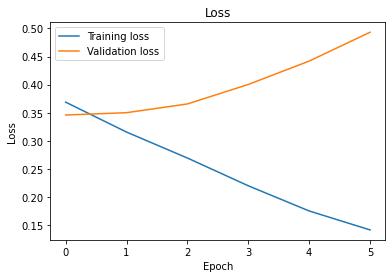

In [55]:
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses_train, label="Training loss")
plt.plot(losses_val, label="Validation loss")
plt.legend()

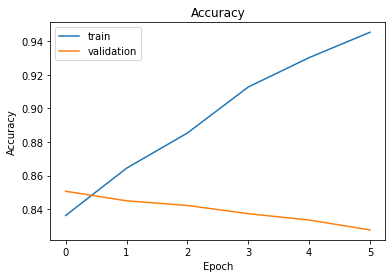

In [56]:
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, label="train")
plt.plot(accuracies_val, label="validation")
plt.legend()
plt.show()


## Load Model
If you want to reload the weights of a previous model for testing of starting training again : 

In [ ]:
model_str = "Wed Nov 02"
model_path = root + "/Models/" + model_str + ".pth"
#model = RNN(embedding, HIDDEN_DIM, DROPOUT, BIDIRECTIONAL, PADDING_ID, NUM_LAYERS, "LSTM")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

RuntimeError: ignored

In [ ]:
model.to(device)

RNN(
  (embedding): Embedding(393023, 300, padding_idx=289283)
  (model): LSTM(300, 128, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

# Test model

### Evaluate the model with the test set

In [57]:
def positive_negative_count(preds, y):
  """
  Returns the accuracy per batch
  """
  pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0

  prob_preds = torch.nn.Softmax(dim=-1)(preds)
  final_preds = torch.argmax(prob_preds, dim=1)

  numpy_preds = final_preds.cpu().numpy()
  numpy_y = y.cpu().numpy()

  for i in range(len(y)):
    if numpy_preds[i] == numpy_y[i]:
      if numpy_y[i] == 0:
        neg_correct += 1
      else:
        pos_correct += 1

    if numpy_y[i] == 0:
      neg_cnt += 1
    else:
      pos_cnt += 1

  return neg_correct, neg_cnt , pos_correct, pos_cnt

In [58]:
neg_correct = 0
neg_cnt = 0
pos_correct = 0
pos_cnt = 0

with torch.no_grad():
  for batch_idx, batch in enumerate(test_dataloader):
    # Data to GPU
    tweet = batch[0].to(device)
    sentiment = batch[1].to(device)

    predictions = model(tweet).squeeze(1)

    neg_correct_tmp, neg_cnt_tmp, pos_correct_tmp, pos_cnt_tmp = positive_negative_count(predictions, sentiment)

    neg_correct += neg_correct_tmp
    neg_cnt += neg_cnt_tmp
    pos_correct += pos_correct_tmp
    pos_cnt += pos_cnt_tmp
  

    # Remove data from GPU
    tweet.to('cpu')
    sentiment.to('cpu')

print("------------------------------------------------------------")
print("                   classified positive   classified negative ")
print("------------------------------------------------------------")
print(" Actual positive     ", pos_correct, "                 ", neg_cnt-neg_correct)
print(" Actual negative     ", pos_cnt-pos_correct, "                 ", neg_correct)
print("------------------------------------------------------------")

print("Acuracy: ", (pos_correct+neg_correct)/(pos_cnt+neg_cnt))
print("Precision: ", pos_correct/(pos_correct + neg_cnt-neg_correct))
print("Recall: ", neg_correct/(neg_correct + pos_cnt-pos_correct))

------------------------------------------------------------
                   classified positive   classified negative 
------------------------------------------------------------
 Actual positive      2061                   435
 Actual negative      458                   2046
------------------------------------------------------------
Acuracy:  0.8214
Precision:  0.8257211538461539
Recall:  0.8170926517571885


### Predict on a given sentence

In [ ]:
def predict(sentence):
  splitted = sentence.split(" ")
  Sentence_tokens = padding_and_encode(splitted, seq_length)
  seq = [Sentence_tokens]
  Sentence_tokens = torch.tensor(seq).to(device)
  
  with torch.no_grad():
    prediction = model(Sentence_tokens).squeeze(1)

  prob_pred = torch.nn.Softmax(dim=-1)(prediction)
  final_pred = torch.argmax(prob_pred, dim=1)
  f = final_pred.cpu().numpy()

  if(f[0] == 1):
    print("Positive")
  else:
    print("Negative")

In [ ]:
predict("I was very disappointed with this series. It had lots of cool graphics and that's about it. The level of detail it went into was minimal, and I always got the feeling the audience was being patronized -- there was a lot of what seemed to me as ")
predict("Great just great! The West Coast got Dirty Harry Callahan, the East Coast got Sharky. Burt Reynolds plays Sharky in ")
predict("I loved that movie")
predict("I hate you")
predict("you are ugly")

Positive
Positive
Positive
Negative
Positive
